In [179]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scipy.stats as stats
import joblib
import os
%matplotlib inline

In [180]:
cc_data_full_data = pd.read_csv('../data/application_record.csv')
credit_status = pd.read_csv('../data/credit_record.csv')

In [181]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

In [182]:
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has_a_car',
    'FLAG_OWN_REALTY':'Has_a_property',
    'CNT_CHILDREN':'Children_count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employmentstatus',
    'NAME_EDUCATION_TYPE':'Educationlevel',
    'NAME_FAMILY_STATUS':'Maritalstatus',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employmentlength',
    'FLAG_MOBIL': 'Has_a_mobilephone',
    'FLAG_WORK_PHONE': 'Has_a_workphone',
    'FLAG_PHONE': 'Has_a_phone',
    'FLAG_EMAIL': 'Has_an_email',
    'OCCUPATION_TYPE': 'Job_title',
    'CNT_FAM_MEMBERS': 'Familymembercount',
    'Account age': 'Accountage'
    })

In [183]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [184]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)
print(cc_train_original)

            ID Gender Has_a_car Has_a_property  Children_count    Income  \
0      5037048      M         Y              Y               0  135000.0   
1      5044630      F         Y              N               1  135000.0   
2      5079079      F         N              Y               2  180000.0   
3      5112872      F         Y              Y               0  360000.0   
4      5105858      F         N              N               0  270000.0   
...        ...    ...       ...            ...             ...       ...   
29160  5067139      F         N              Y               0  112500.0   
29161  5029193      F         N              Y               1  135000.0   
29162  5047710      F         N              Y               0   76500.0   
29163  5009886      F         N              Y               0  157500.0   
29164  5062632      F         N              Y               0  585000.0   

           Employmentstatus                 Educationlevel  \
0                   Worki

In [185]:
cc_train_original.shape

(29165, 20)

In [186]:
cc_test_original.shape

(7292, 20)

In [187]:
cc_train_original.to_csv('../data/train1.csv',index=False)
cc_test_original.to_csv('../data/test1.csv',index=False)

In [188]:
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()
print(cc_test_copy,cc_train_copy)

           ID Gender Has_a_car Has_a_property  Children_count    Income  \
0     5091261      F         N              Y               0  202500.0   
1     5096963      M         Y              N               0  675000.0   
2     5087880      F         N              N               0  234000.0   
3     5021949      F         Y              Y               0  445500.0   
4     5105705      F         Y              N               0  225000.0   
...       ...    ...       ...            ...             ...       ...   
7287  5115415      F         Y              Y               0  135000.0   
7288  5068826      F         Y              Y               0  157500.0   
7289  5026088      F         N              Y               0   67500.0   
7290  5142701      F         Y              N               0   95850.0   
7291  5022903      F         N              Y               1  135000.0   

          Employmentstatus                 Educationlevel   Maritalstatus  \
0            State ser

In [189]:
cc_data_full_data.head()

,ID,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Age,Employmentlength,Has_a_mobilephone,Has_a_workphone,Has_a_phone,Has_an_email,Job_title,Familymembercount,Accountage,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [190]:
cc_data_full_data.describe()

,ID,Children_count,Income,Age,Employmentlength,Has_a_mobilephone,Has_a_workphone,Has_a_phone,Has_an_email,Familymembercount,Accountage
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000


In [191]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 36457 non-null  int64  
 1   Gender             36457 non-null  object 
 2   Has_a_car          36457 non-null  object 
 3   Has_a_property     36457 non-null  object 
 4   Children_count     36457 non-null  int64  
 5   Income             36457 non-null  float64
 6   Employmentstatus   36457 non-null  object 
 7   Educationlevel     36457 non-null  object 
 8   Maritalstatus      36457 non-null  object 
 9   Dwelling           36457 non-null  object 
 10  Age                36457 non-null  int64  
 11  Employmentlength   36457 non-null  int64  
 12  Has_a_mobilephone  36457 non-null  int64  
 13  Has_a_workphone    36457 non-null  int64  
 14  Has_a_phone        36457 non-null  int64  
 15  Has_an_email       36457 non-null  int64  
 16  Job_title          251

In [192]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat
# function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'Age':
            # change the feature to be express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Employment length':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = cc_train_copy['Employmentlength'][cc_train_copy['Employmentlength'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))
# function to create a pie chart plot
def create_pie_plot(df,feature):
    match feature:
        case 'Dwelling' | 'Educationlevel':
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best',labels=ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm_cal(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            fig, ax = plt.subplots(figsize=(8,8))
            # %1.2f%% display decimals in the pie chart with 2 decimal places
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
            plt.title('Pie chart of {}'.format(feature))
            plt.legend(loc='best')
            plt.axis('equal')
            return plt.show()
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'Maritalstatus' | 'Dwelling' | 'Jobtitle' | 'Employmentstatus' | 'Educationlevel':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
# function to create a box plot
def create_box_plot(df,feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(2,8))
            # change the feature to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employmentlength':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = cc_train_copy['Employmentlength'][cc_train_copy['Employmentlength'] < 0]
            # employement length in days is a negative number so we need to change it to positive and change it to days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case 'Accountage':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employmentlength':
            employment_len_no_ret = cc_train_copy['Employmentlength'][cc_train_copy['Employmentlength'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Accountage':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employmentlength':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = cc_train_copy['Employmentlength'][cc_train_copy['Employmentlength'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employmentlength','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employmentlength'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
# High risk vs low risk applicants compared on a bar plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [193]:
cc_train_copy.shape

(29165, 20)

In [194]:
job_title_nan_count = cc_train_copy['Job_title'].isna().sum()
job_title_nan_count
rows_total_count = cc_train_copy.shape[0]
rows_total_count
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


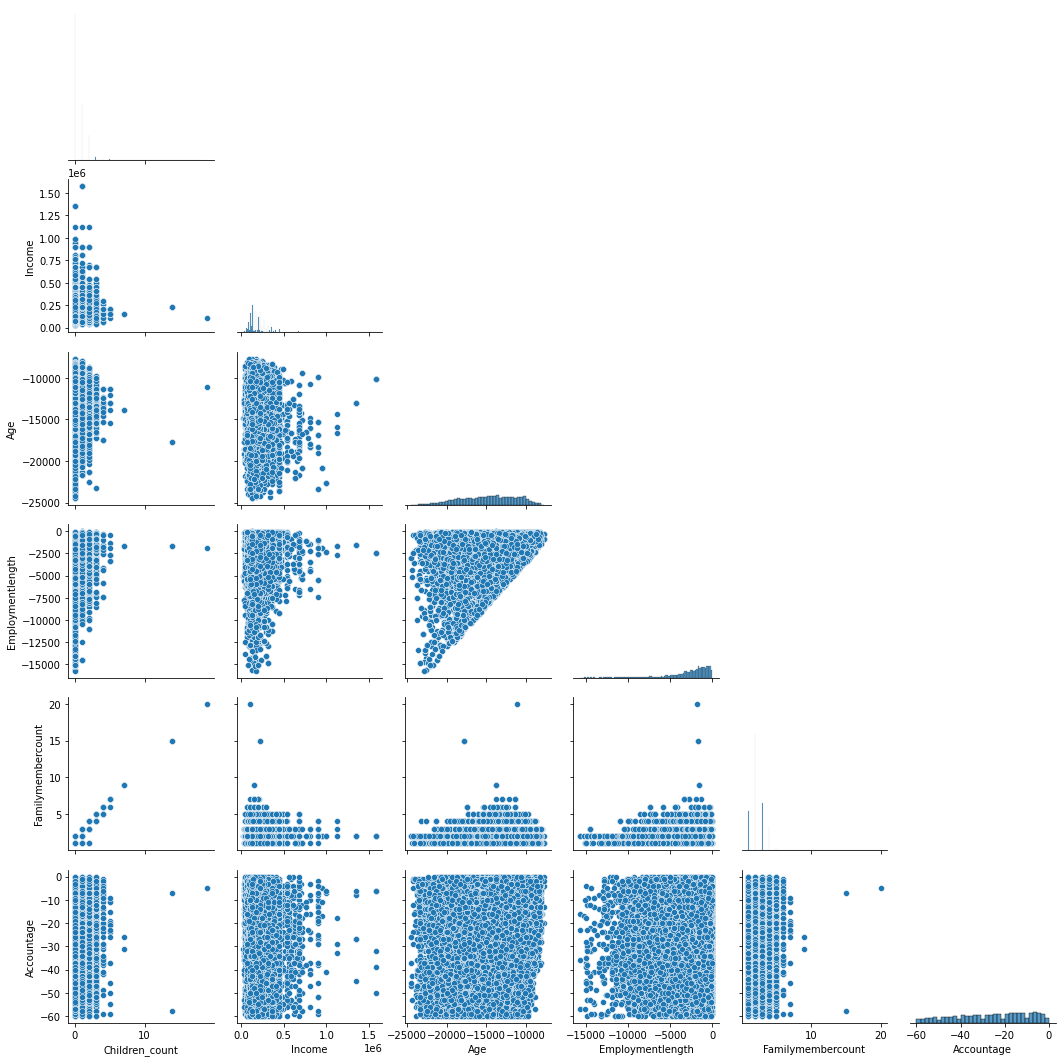

In [195]:
sns.pairplot(cc_train_copy[cc_train_copy['Employmentlength'] < 0].drop(['ID','Has_a_mobilephone', 'Has_a_workphone', 'Has_a_phone', 'Has_an_email','Is high risk'],axis=1),corner=True)
plt.show()

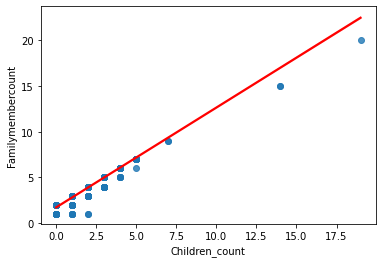

In [196]:
sns.regplot(x='Children_count',y='Familymembercount',data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

In [197]:
y_age = np.abs(cc_train_copy['Age'])/365.25

In [198]:
x_employ_length = np.abs(cc_train_copy[cc_train_copy['Employmentlength'] < 0]['Employmentlength'])/365.25

In [199]:
is_high_risk_int = cc_train_copy['Is high risk'].astype('int32')
cc_train_copy.head()

,ID,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Age,Employmentlength,Has_a_mobilephone,Has_a_workphone,Has_a_phone,Has_an_email,Job_title,Familymembercount,Accountage,Is high risk
0,5037048,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,With parents,-16271,-3111,1,0,0,0,Core staff,2.0,-17.0,0
1,5044630,F,Y,N,1,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,-10130,-1651,1,0,0,0,Accountants,2.0,-1.0,0
2,5079079,F,N,Y,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12821,-5657,1,0,0,0,Laborers,4.0,-38.0,0
3,5112872,F,Y,Y,0,360000.0,Commercial associate,Higher education,Single / not married,House / apartment,-20929,-2046,1,0,0,1,Managers,1.0,-11.0,0
4,5105858,F,N,N,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16207,-515,1,0,1,0,NaN,1.0,-41.0,0


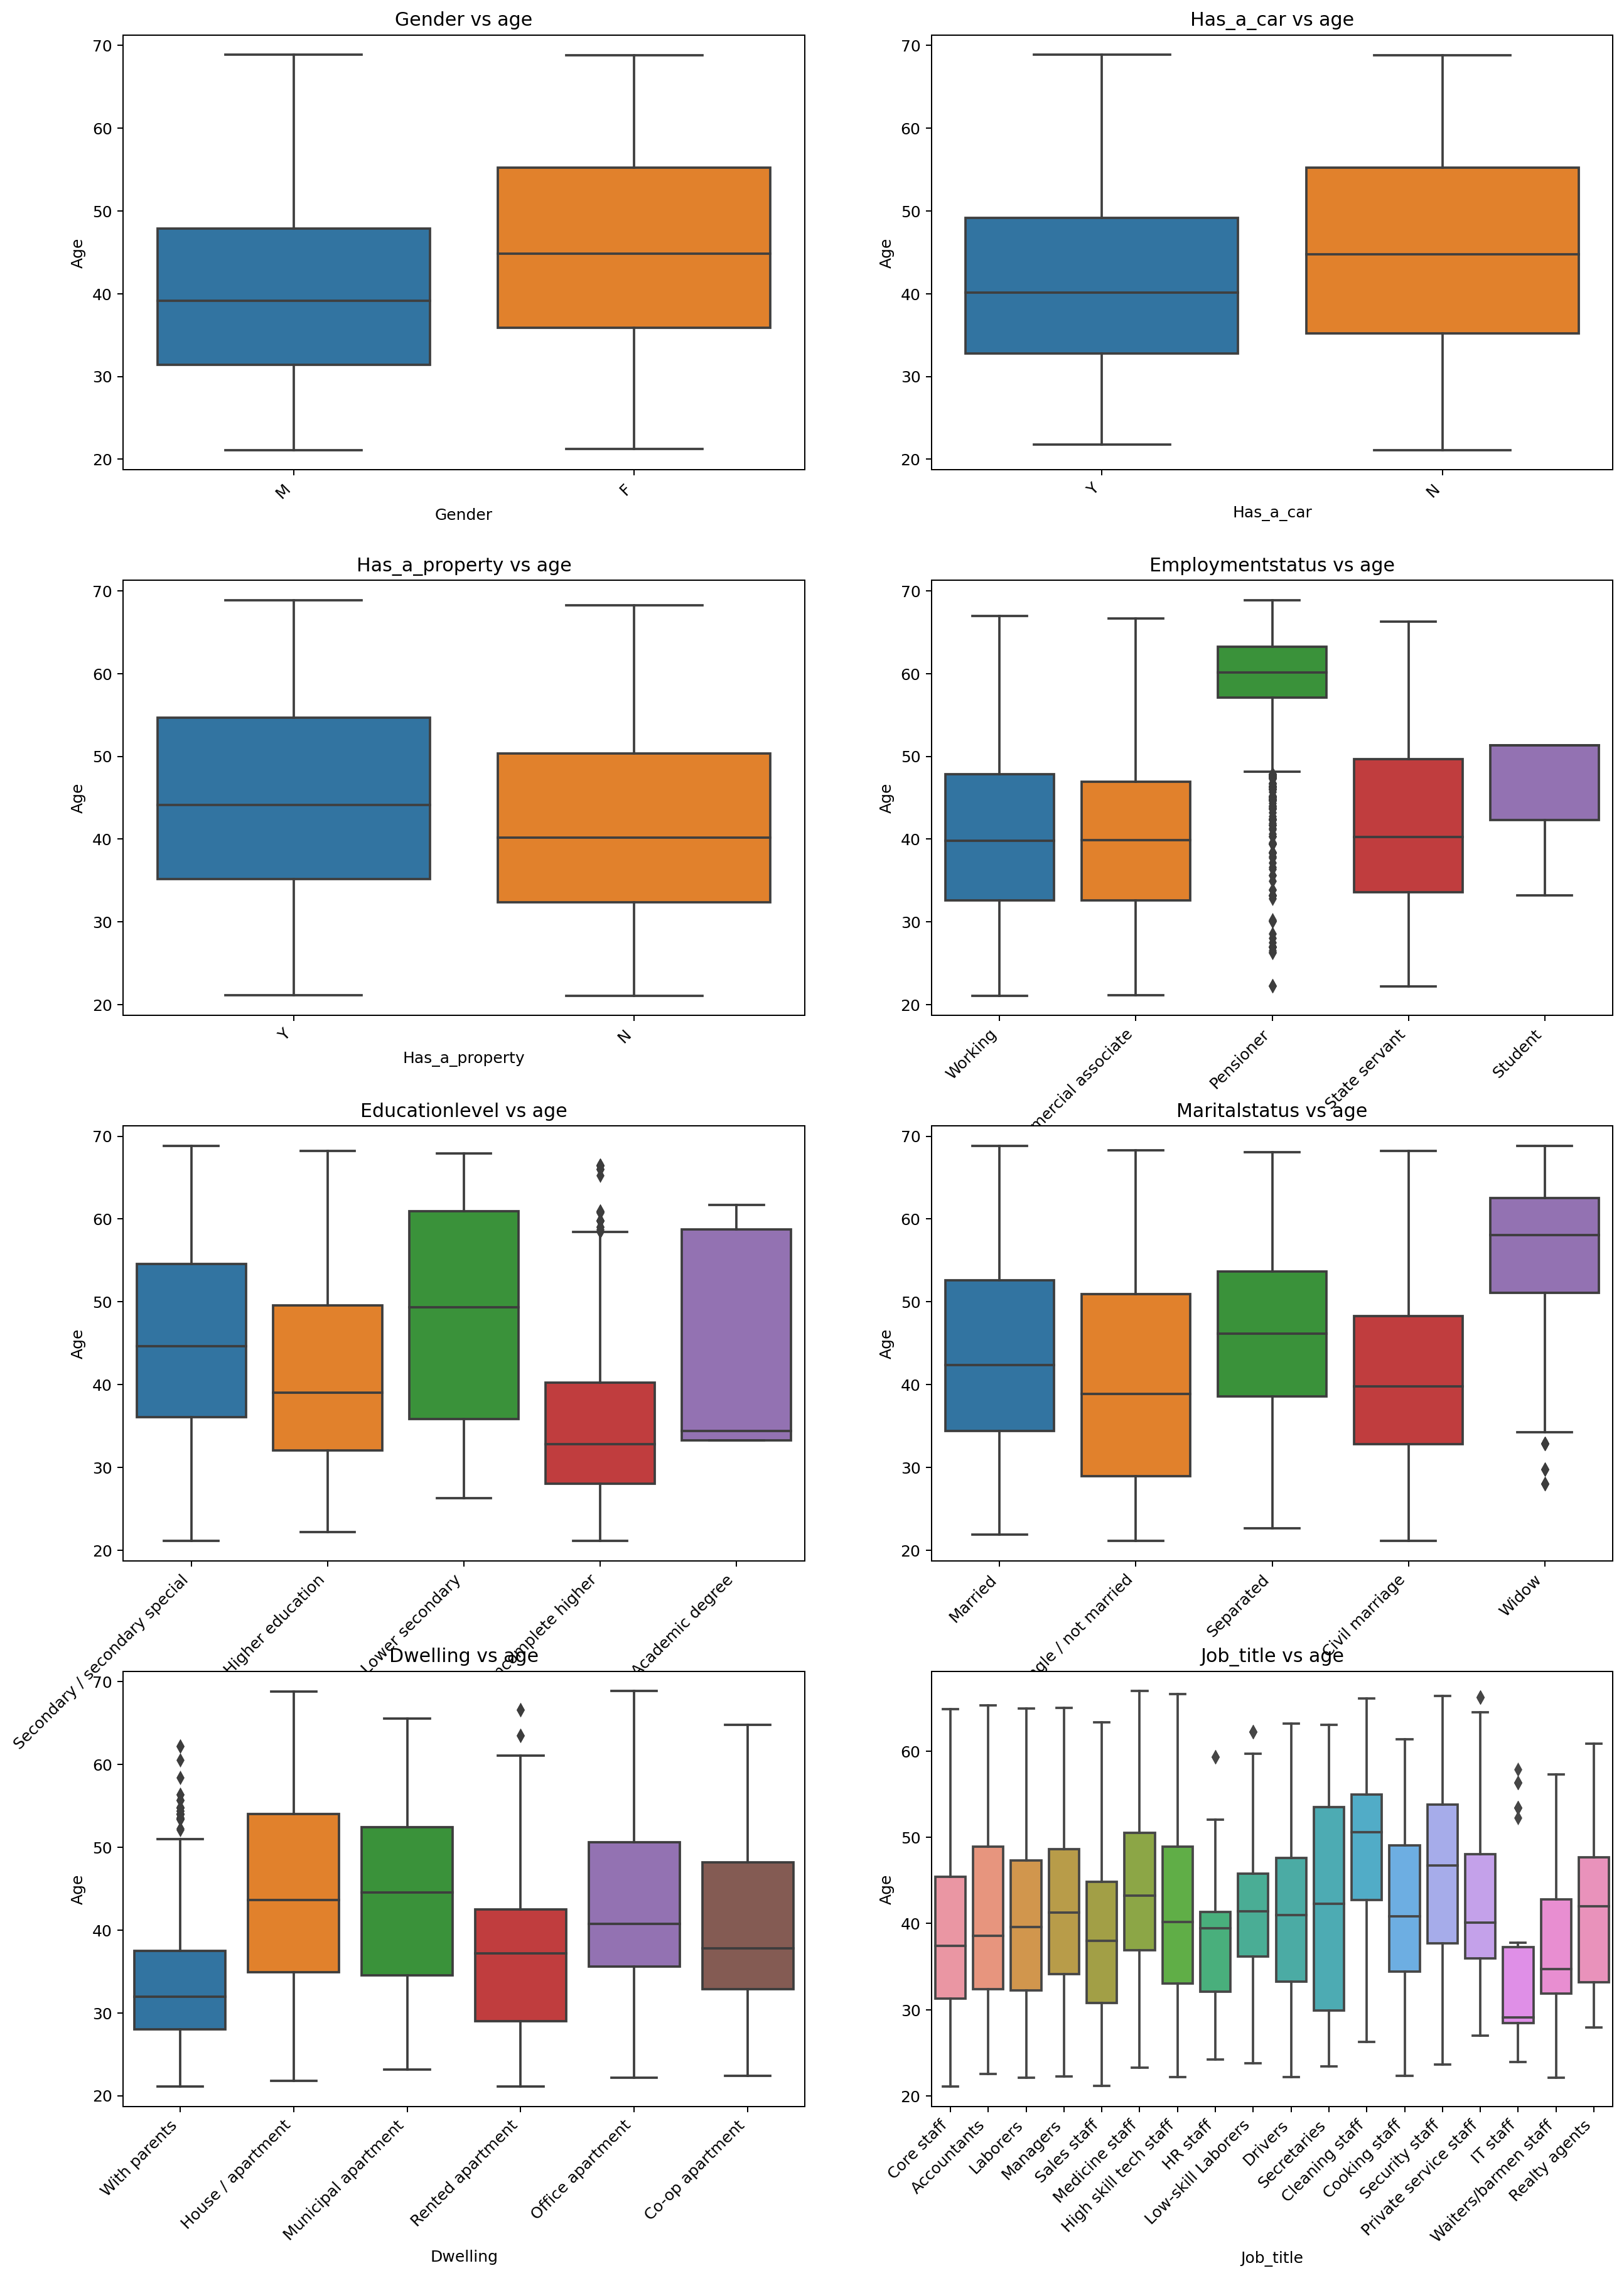

In [200]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has_a_car', 'Has_a_property', 'Employmentstatus', 'Educationlevel', 'Maritalstatus', 'Dwelling', 'Job_title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

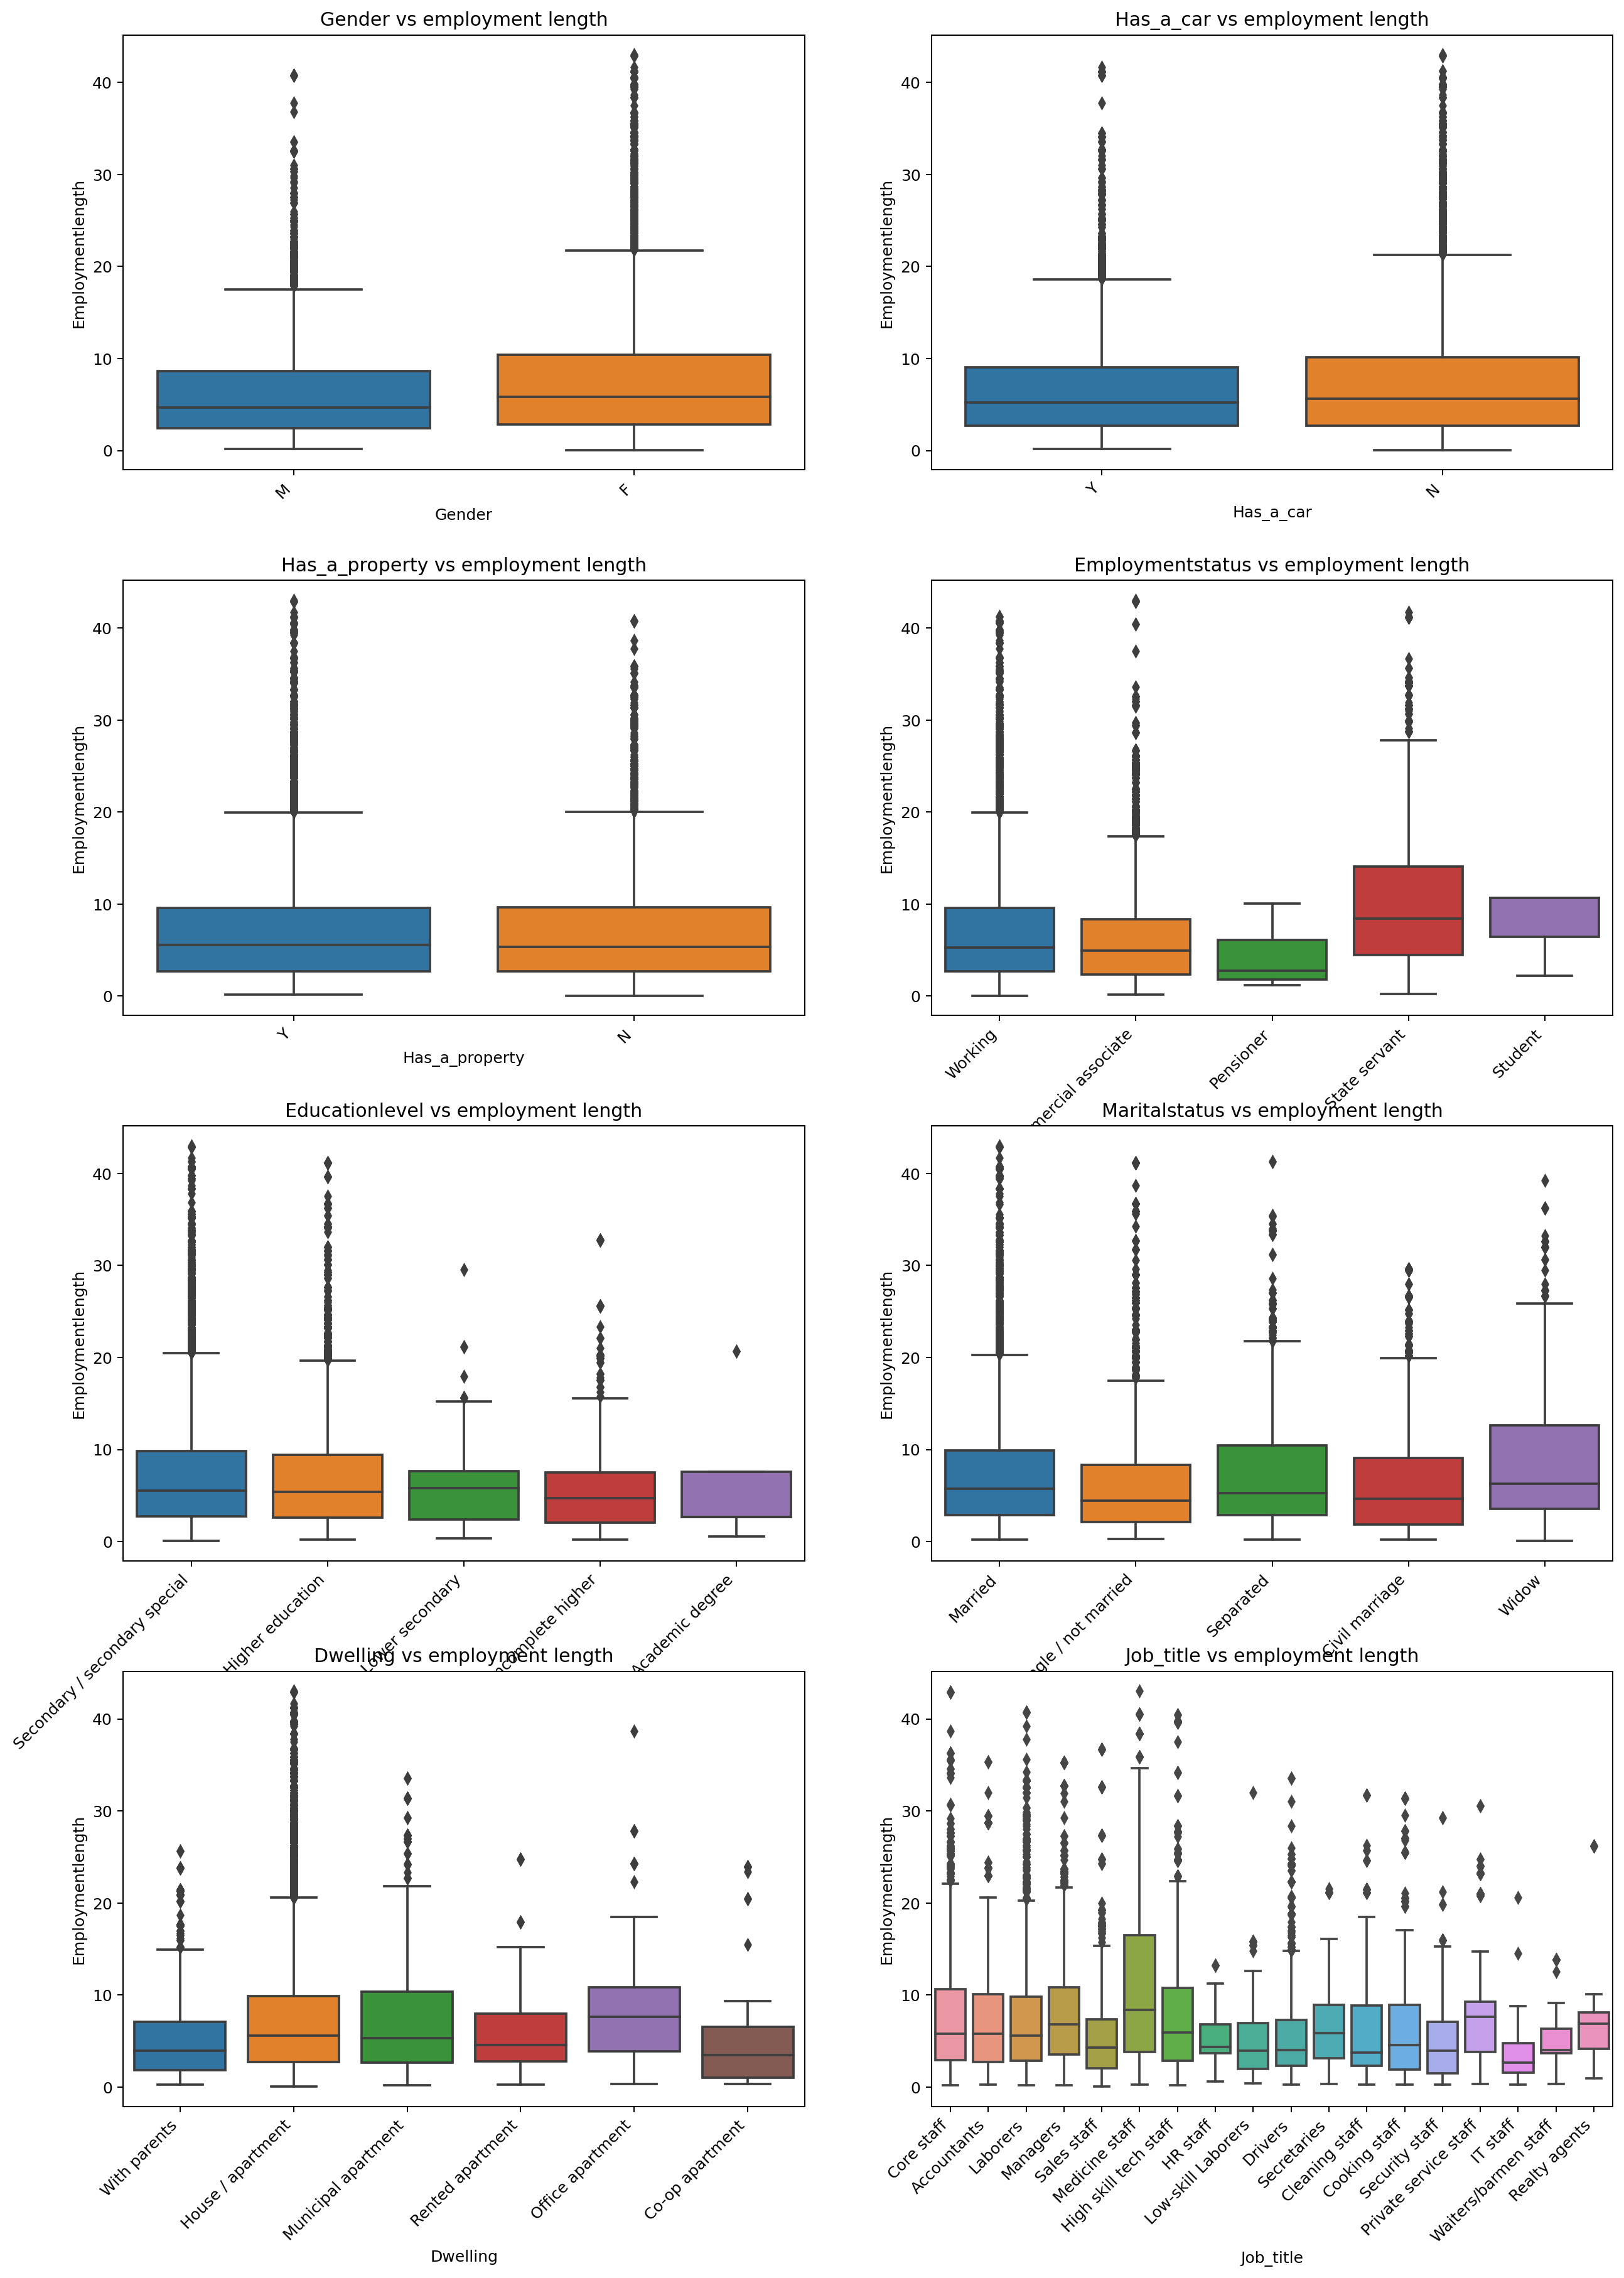

In [201]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employmentlength'] < 0]['Employmentlength'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employmentlength')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

In [202]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_outliers = ['Familymembercount','Income', 'Employmentlength']):
        self.feat_with_outliers = feat_with_outliers
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(.75)
            IQR = Q3 - Q1
            # keep the data within 3 IQR
            df = df[~((df[self.feat_with_outliers] < (Q1 - 3 * IQR)) |(df[self.feat_with_outliers] > (Q3 + 3 * IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [203]:
class DropFeatures(BaseEstimator,TransformerMixin):
    def __init__(self,feature_to_drop = ['ID','Has_a_mobilephone','Children_count','Job_title','Accountage']):
        self.feature_to_drop = feature_to_drop
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop,axis=1,inplace=True)
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [204]:
class TimeConversionHandler(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employmentlength', 'Age']):
        self.feat_with_days = feat_with_days
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[['Employmentlength','Age']] = np.abs(X[['Employmentlength','Age']])
            return X
        else:
            print("One or more features are not in the dataframe")
            return X

In [205]:
class RetireeHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employmentlength'][df['Employmentlength'] == 365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print("Employment length is not in the dataframe")
            return df

In [206]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [207]:
class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has_a_workphone','Has_a_phone','Has_an_email']):
        self.feat_with_num_enc = feat_with_num_enc
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [208]:
class OneHotWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,one_hot_enc_ft = ['Gender', 'Maritalstatus', 'Dwelling', 'Employmentstatus', 'Has_a_car', 'Has_a_property', 'Has_a_workphone', 'Has_a_phone', 'Has_an_email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            # function to one hot encode the features in one_hot_enc_ft
            def one_hot_enc(df,one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                # get the result of the one hot encoding columns names
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                # change the array of the one hot encoding to a dataframe with the column names
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(),columns=feat_names_one_hot_enc,index=df.index)
                return df
            # function to concatenat the one hot encoded features with the rest of features that were not encoded
            def concat_with_rest(df,one_hot_enc_df,one_hot_enc_ft):
                # get the rest of the features
                rest_of_features = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                # concatenate the rest of the features with the one hot encoded features
                df_concat = pd.concat([one_hot_enc_df, df[rest_of_features]],axis=1)
                return df_concat
            # one hot encoded dataframe
            one_hot_enc_df = one_hot_enc(df,self.one_hot_enc_ft)
            # returns the concatenated dataframe
            full_df_one_hot_enc = concat_with_rest(df,one_hot_enc_df,self.one_hot_enc_ft)
            return full_df_one_hot_enc
        else:
            print("One or more features are not in the dataframe")
            return df

In [209]:
class OrdinalFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Educationlevel']):
        self.ordinal_enc_ft = ordinal_enc_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Education level' in df.columns:
            ordinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = ordinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print("Education level is not in the dataframe")
            return df

In [210]:
class MinMaxWithFeatNames(BaseEstimator,TransformerMixin):
    def __init__(self,min_max_scaler_ft = ['Age', 'Income', 'Employmentlength']):
        self.min_max_scaler_ft = min_max_scaler_ft
    def fit(self,df):
        return self
    def transform(self,df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

In [211]:
class ChangeToNumTarget(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print("Is high risk is not in the dataframe")
            return df

In [212]:
class Oversample(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,df):
        return self
    def transform(self,df):
        if 'Is high risk' in df.columns:
            # smote function to oversample the minority class to fix the imbalance data
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:, df.columns != 'Is high risk'],df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal),pd.DataFrame(y_bal)],axis=1)
            return df_bal
        else:
            print("Is high risk is not in the dataframe")
            return df

In [213]:
def full_pipeline(df):
    # Create the pipeline that will call all the class from OutlierRemoval to OversampleSMOTE in one go
    pipeline = Pipeline([
        ('outlier_remover', OutlierRemover()),
        ('feature_dropper', DropFeatures()),
        ('time_conversion_handler', TimeConversionHandler()),
        ('retiree_handler', RetireeHandler()),
        ('skewness_handler', SkewnessHandler()),
        ('binning_num_to_yn', BinningNumToYN()),
        ('one_hot_with_feat_names', OneHotWithFeatNames()),
        ('ordinal_feat_names', OrdinalFeatNames()),
        ('min_max_with_feat_names', MinMaxWithFeatNames()),
        ('change_to_num_target', ChangeToNumTarget()),
        ('oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [214]:
pd.options.mode.chained_assignment = None  # Hide the copy warnin
cc_train_copy=pd.DataFrame(cc_train_copy)
cc_train_copy=pd.DataFrame(cc_train_copy)
cc_train_copy.drop(['ID',"Age",'Employmentlength','Accountage',"Has_a_workphone","Has_a_phone","Has_an_email"], axis = 1, inplace = True) 
cc_train_copy

,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Has_a_mobilephone,Job_title,Familymembercount,Is high risk
0,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Married,With parents,1,Core staff,2.0,0
1,F,Y,N,1,135000.0,Commercial associate,Higher education,Single / not married,House / apartment,1,Accountants,2.0,0
2,F,N,Y,2,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,Laborers,4.0,0
3,F,Y,Y,0,360000.0,Commercial associate,Higher education,Single / not married,House / apartment,1,Managers,1.0,0
4,F,N,N,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,1,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29160,F,N,Y,0,112500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,1,NaN,1.0,0
29161,F,N,Y,1,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,Core staff,3.0,0
29162,F,N,Y,0,76500.0,Working,Secondary / secondary special,Married,House / apartment,1,Managers,2.0,0
29163,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,1,NaN,2.0,0


In [215]:
cc_train_copy['Gender']=cc_train_copy['Gender'].apply(lambda x: 1 if x=="M" else 0)
cc_train_copy['Gender'].value_counts()

Gender
0    19549
1     9616
Name: count, dtype: int64

In [216]:
cc_train_copy['Has_a_car'].value_counts()
cc_train_copy['Has_a_car']=cc_train_copy['Has_a_car'].apply(lambda x: 1 if x=="Y" else 0)
cc_train_copy['Has_a_car'].value_counts()

Has_a_car
0    18128
1    11037
Name: count, dtype: int64

In [217]:
cc_train_copy['Has_a_property']=cc_train_copy['Has_a_property'].apply(lambda x: 1 if x=="Y" else 0)
cc_train_copy['Has_a_property'].value_counts()

Has_a_property
1    19557
0     9608
Name: count, dtype: int64

In [218]:
cc_train_copy['Job_title'].value_counts()

Job_title
Laborers                 5004
Core staff               2866
Sales staff              2773
Managers                 2422
Drivers                  1722
High skill tech staff    1133
Accountants               998
Medicine staff            956
Cooking staff             521
Security staff            464
Cleaning staff            425
Private service staff     287
Low-skill Laborers        138
Waiters/barmen staff      127
Secretaries               122
HR staff                   72
Realty agents              60
IT staff                   48
Name: count, dtype: int64

In [219]:
to_numeric={"Working":1,"Commercial associate":2,"Pensioner":3,"State servant":4,"Student":5,
"Secondary / secondary special":1,"Higher education":2,"Incomplete higher":3,"Lower secondary":4,"Academic degree":5,
"Married":1,"Single / not married":2,"Civil marriage":3,"Separated":4,"Widow":5,
"House / apartment":1,"With parents":2,"Municipal apartment":3,"Rented apartment":4,"Office apartment":5,"Co-op apartment":6,
'Core staff':1, 'Accountants':2, 'Laborers':3, 'Managers':4, "NaN":0,'Sales staff':5, 'Medicine staff':6, 'High skill tech staff':7,
'HR staff':8, 'Low-skill Laborers':9, 'Drivers':10, 'Secretaries':11,
'Cleaning staff':12, 'Cooking staff':13, 'Security staff':14,'Private service staff':15, 'IT staff':16, 'Waiters/barmen staff':17,
'Realty agents':18,
}


In [220]:
cc_train_copy =cc_train_copy.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)
cc_train_copy

,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Has_a_mobilephone,Job_title,Familymembercount,Is high risk
0,1,1,1,0,135000.0,1,1,1,2,1,1.0,2.0,0
1,0,1,0,1,135000.0,2,2,2,1,1,2.0,2.0,0
2,0,0,1,2,180000.0,2,1,1,1,1,3.0,4.0,0
3,0,1,1,0,360000.0,2,2,2,1,1,4.0,1.0,0
4,0,0,0,0,270000.0,1,1,4,1,1,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29160,0,0,1,0,112500.0,3,1,2,1,1,NaN,1.0,0
29161,0,0,1,1,135000.0,2,1,1,1,1,1.0,3.0,0
29162,0,0,1,0,76500.0,1,1,1,1,1,4.0,2.0,0
29163,0,0,1,0,157500.0,3,1,3,1,1,NaN,2.0,0


In [221]:
cc_train_copy['Job_title'] = cc_train_copy['Job_title'].replace(np.nan, 0)

In [222]:
X_cc_train_prep, y_cc_train_prep = cc_train_copy.loc[:, cc_train_copy.columns != 'Is high risk'], cc_train_copy['Is high risk'].astype('int64')
LR = LogisticRegression()
LR.fit(X_cc_train_prep, y_cc_train_prep)

LogisticRegression()

In [223]:
cc_test_copy.head(5)

,ID,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Age,Employmentlength,Has_a_mobilephone,Has_a_workphone,Has_a_phone,Has_an_email,Job_title,Familymembercount,Accountage,Is high risk
0,5091261,F,N,Y,0,202500.0,State servant,Secondary / secondary special,Separated,House / apartment,-16834,-1692,1,0,0,0,Medicine staff,1.0,-6.0,0
1,5096963,M,Y,N,0,675000.0,Commercial associate,Higher education,Married,House / apartment,-18126,-948,1,0,1,0,Managers,2.0,-16.0,0
2,5087880,F,N,N,0,234000.0,State servant,Higher education,Civil marriage,House / apartment,-21967,-5215,1,0,0,1,Core staff,2.0,-52.0,0
3,5021949,F,Y,Y,0,445500.0,Commercial associate,Higher education,Married,House / apartment,-12477,-456,1,0,0,0,Managers,2.0,-54.0,0
4,5105705,F,Y,N,0,225000.0,Working,Secondary / secondary special,Married,Municipal apartment,-12155,-667,1,0,0,0,Laborers,2.0,-48.0,0


In [224]:
to_numeric={"Working":1,"Commercial associate":2,"Pensioner":3,"State servant":4,"Student":5,
"Secondary / secondary special":1,"Higher education":2,"Incomplete higher":3,"Lower secondary":4,"Academic degree":5,
"Married":1,"Single / not married":2,"Civil marriage":3,"Separated":4,"Widow":5,
"House / apartment":1,"With parents":2,"Municipal apartment":3,"Rented apartment":4,"Office apartment":5,"Co-op apartment":6,
'Core staff':1, 'Accountants':2, 'Laborers':3, 'Managers':4, "NaN":0,'Sales staff':5, 'Medicine staff':6, 'High skill tech staff':7,
'HR staff':8, 'Low-skill Laborers':9, 'Drivers':10, 'Secretaries':11,
'Cleaning staff':12, 'Cooking staff':13, 'Security staff':14,'Private service staff':15, 'IT staff':16, 'Waiters/barmen staff':17,
'Realty agents':18,"M":1,"F":0,"Y":1,"N":0
}
cc_test_copy=pd.DataFrame(cc_test_copy)
cc_test_copy.drop(['ID',"Age",'Employmentlength','Accountage',"Has_a_workphone","Has_a_phone","Has_an_email"], axis = 1, inplace = True) 
cc_test_copy =cc_test_copy.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)
cc_test_copy[]

,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Has_a_mobilephone,Job_title,Familymembercount,Is high risk
0,0,0,1,0,202500.0,4,1,4,1,1,6.0,1.0,0
1,1,1,0,0,675000.0,2,2,1,1,1,4.0,2.0,0
2,0,0,0,0,234000.0,4,2,3,1,1,1.0,2.0,0
3,0,1,1,0,445500.0,2,2,1,1,1,4.0,2.0,0
4,0,1,0,0,225000.0,1,1,1,3,1,3.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7287,0,1,1,0,135000.0,1,1,1,1,1,NaN,2.0,0
7288,0,1,1,0,157500.0,1,2,1,1,1,10.0,2.0,0
7289,0,0,1,0,67500.0,1,1,5,1,1,NaN,1.0,0
7290,0,1,0,0,95850.0,2,1,1,1,1,3.0,2.0,0


In [238]:
cc_test_copy.loc[cc_test_copy['Is high risk'] == 1]

,Gender,Has_a_car,Has_a_property,Children_count,Income,Employmentstatus,Educationlevel,Maritalstatus,Dwelling,Has_a_mobilephone,Job_title,Familymembercount,Is high risk
69,0,1,0,0,450000.0,3,2,1,1,1,4.0,2.0,1
99,1,1,1,0,225000.0,3,2,4,1,1,0.0,1.0,1
109,0,0,1,0,67500.0,1,1,1,1,1,13.0,2.0,1
223,0,0,1,0,216000.0,3,1,5,1,1,0.0,1.0,1
243,1,1,1,1,180000.0,2,2,1,1,1,0.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6901,0,0,0,0,180000.0,1,1,2,2,1,15.0,1.0,1
6958,0,0,0,3,112500.0,1,3,1,3,1,5.0,5.0,1
7007,0,0,1,0,89100.0,3,1,5,1,1,0.0,1.0,1
7070,1,1,0,0,459000.0,2,1,1,1,1,10.0,2.0,1


In [225]:

cc_test_copy['Job_title'] = cc_test_copy['Job_title'].replace(np.nan, 0)

In [235]:
cc_test_copy
cc_test_copy['Is high risk'].value_counts()

Is high risk
0    7175
1     117
Name: count, dtype: int64

In [227]:
X_cc_test_prep, y_cc_test_prep = cc_test_copy.loc[:, cc_test_copy.columns != 'Is high risk'], cc_test_copy['Is high risk'].astype('int64')

In [228]:
y_predict = LR.predict(X_cc_test_prep)

#  prediction Summary by species
print(classification_report(y_cc_test_prep, y_predict))
from sklearn.metrics import accuracy_score
# Accuracy score
LR_SC = accuracy_score(y_predict,y_cc_test_prep)
print(f"{round(LR_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7175
           1       0.00      0.00      0.00       117

    accuracy                           0.98      7292
   macro avg       0.49      0.50      0.50      7292
weighted avg       0.97      0.98      0.98      7292

98.4% Accurate


c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [229]:
SGDC = SGDClassifier(random_state=42,loss='perceptron')
SGDC.fit(X_cc_train_prep, y_cc_train_prep)
y_predict = LR.predict(X_cc_test_prep)
#  prediction Summary by species
print(classification_report(y_cc_test_prep, y_predict))
# Accuracy score
SGDC_SC = accuracy_score(y_predict,y_cc_test_prep)
print(f"{round(LR_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7175
           1       0.00      0.00      0.00       117

    accuracy                           0.98      7292
   macro avg       0.49      0.50      0.50      7292
weighted avg       0.97      0.98      0.98      7292

98.4% Accurate


c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [233]:
GBC = GradientBoostingClassifier(random_state=50)
GBC.fit(X_cc_train_prep, y_cc_train_prep)
y_predict = LR.predict(X_cc_test_prep)
#  prediction Summary by species
print(classification_report(y_cc_test_prep, y_predict))
# Accuracy score
GBC_SC = accuracy_score(y_predict,y_cc_test_prep)
print(f"{round(LR_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7175
           1       0.00      0.00      0.00       117

    accuracy                           0.98      7292
   macro avg       0.49      0.50      0.50      7292
weighted avg       0.97      0.98      0.98      7292

98.4% Accurate


c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [234]:
ABC = AdaBoostClassifier(random_state=30)
ABC.fit(X_cc_train_prep, y_cc_train_prep)
y_predict = LR.predict(X_cc_test_prep)
#  prediction Summary by species
print(classification_report(y_cc_test_prep, y_predict))
# Accuracy score
ABC_SC = accuracy_score(y_predict,y_cc_test_prep)
print(f"{round(LR_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7175
           1       0.00      0.00      0.00       117

    accuracy                           0.98      7292
   macro avg       0.49      0.50      0.50      7292
weighted avg       0.97      0.98      0.98      7292

98.4% Accurate


c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sony\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo